In [53]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from scipy.optimize import minimize
from copy import deepcopy
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
import chainer
import chainer.links as L
import chainer.functions as F

In [46]:
#入力xは多次元(n)で出力yはクラスラベル(onehot encoding)、qubit数はとりあえずnにする
num_class = 2

In [51]:
num_h = 3

In [ ]:
d = {}

In [4]:
def make_data(num,r):
    array = []
    for i in range(num):
        radius = r + np.random.uniform(-0.05,0.05,1)
        theta = np.random.uniform(0,2*np.pi,1)
        a,b = radius*np.cos(theta),radius*np.sin(theta)
        array.append([a[0],b[0]])
    array = np.array(array)
    return array

In [5]:
x_train = np.vstack((make_data(30,0.95),make_data(30,0.5))) #0.95にしておけば範囲外に出ることはなくなると思う
y_train = np.hstack((np.array([0]*30),np.array([1]*30)))

x_test = np.vstack((make_data(10,1),make_data(10,0.5)))
y_test = np.hstack((np.array([0]*10),np.array([1]*10)))

In [72]:
#これは正規化が必要な時に行う、一応やったほうが安全？
mn = MinMaxScaler(feature_range=(-1,1),copy = True)
x_train = mn.fit_transform(x_train)
x_test = mn.fit_transform(x_test)

x_train[x_train < -1] = -1
x_train[x_train > 1] = 1
x_test[x_test < -1] = -1
x_test[x_test > 1] = 1

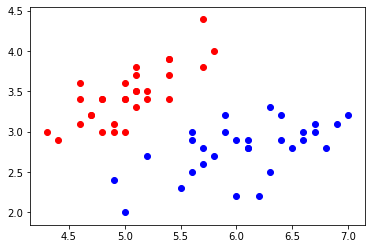

In [47]:
iris = datasets.load_iris()
x_train = np.vstack((iris.data[:30,[0,1]],iris.data[50:80,[0,1]])).astype(np.float32)
y_train = np.hstack((iris.target[:30],iris.target[50:80])).astype(np.int32)

x_test = np.vstack((iris.data[40:50,[0,1]],iris.data[90:100,[0,1]])).astype(np.float32)
y_test = np.hstack((iris.target[40:50],iris.target[90:100])).astype(np.int32)

for i in range(len(x_train)):
    if y_train[i] == 0:
        plt.scatter(x_train_old[i][0],x_train_old[i][1],color = "red")
    else:
        plt.scatter(x_train_old[i][0],x_train_old[i][1],color = "blue")

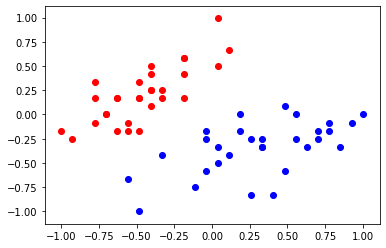

In [78]:
#これは正規化が必要な時に行う、一応やったほうが安全？
mn = MinMaxScaler(feature_range=(-1,1),copy = True)
x_train = mn.fit_transform(x_train)
x_test = mn.fit_transform(x_test)

x_train[x_train < -1] = -1
x_train[x_train > 1] = 1
x_test[x_test < -1] = -1
x_test[x_test > 1] = 1
x_train.astype(np.float32)
x_test.astype(np.float32)
for i in range(len(x_train)):
    if y_train[i] == 0:
        plt.scatter(x_train[i][0],x_train[i][1],color = "red")
    else:
        plt.scatter(x_train[i][0],x_train[i][1],color = "blue")

In [49]:
class Net1(chainer.Chain):

    def __init__(self, n_in=2, n_hidden=3, n_out=2):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        return h

In [20]:
class Net2(chainer.Chain):

    def __init__(self,n_in=2,n_hidden=3,n_out=2):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in,n_hidden)
            self.l2 = L.Linear(n_hidden,n_hidden)
            self.l3 = L.Linear(n_hidden,n_out)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

In [79]:
net = Net1(n_hidden=num_h)
optimizer = chainer.optimizers.SGD()
optimizer.setup(net)

In [81]:
n_epoch = 500
for epoch in range(n_epoch):
    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(len(x_train)))
    for i in range(len(order)):
        # バッチを準備
        index = order[i]
        x_train_batch = x_train[index:index+1].astype(np.float32)
        y_train_batch = y_train[index:index+1].astype(np.int32)
        
        # 予測値を出力
        y_pred = net(x_train_batch)
        # 目的関数を適用
        loss_train_batch = F.softmax_cross_entropy(y_pred,y_train_batch)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

In [60]:
def softmax(x):  #xはndarrayじゃなきゃだめ
    max_x = np.max(x)
    exp_x = np.exp(x-max_x)
    return exp_x / np.sum(exp_x)

In [82]:
def plot_decision_regions():
    x1_min,x1_max = x_train[:,0].min(),x_train[:,0].max()
    x2_min,x2_max = x_train[:,1].min(),x_train[:,1].max()
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,0.08),
                         np.arange(x2_min,x2_max,0.08))
    points = np.array([xx1.ravel(),xx2.ravel()]).T
    z = []
    for i,j in points:
        y_pred = net(np.array([i,j],dtype=np.float32).reshape(1,len(x_train[0]))).array.reshape(num_class,)
        y_pred = softmax(y_pred)
        y_pred = list(y_pred)
        z.append(y_pred.index(max(y_pred)))
    z = np.array(z)
    z = z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,z,alpha = 0.3)
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    
    for i in range(len(x_train)):
        if y_train[i]== 0:
            plt.scatter(x_train[i][0],x_train[i][1],color = "red")
        else:
            plt.scatter(x_train[i][0],x_train[i][1],color = "blue") 

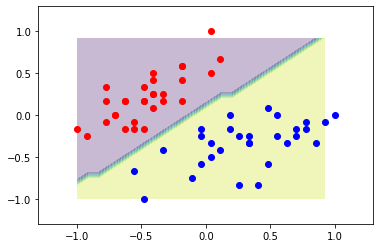

In [83]:
plot_decision_regions()

In [7]:
#ここまでが学習フェーズ、ここから下はNICの計算フェーズ

In [91]:
par = np.array([0]*(5*num_h+2),dtype=np.float32) #ここで学習済パラメータを1次元化する
for i in range(2*num_h):
    par[i] = net.l1.W.array[i//2][i%2]
for i in range(2*num_h,3*num_h):
    par[i] = net.l1.b.array[i%num_h]
for i in range(3*num_h,5*num_h):
    par[i] = net.l2.W.array[(i-3*num_h)//num_h][(i-3*num_h)%num_h]
par[5*num_h] = net.l2.b.array[0]
par[5*num_h+1] = net.l2.b.array[1]

In [111]:
class Net_after_optimization(chainer.Chain):
    def __init__(self,W_l1,b_l1,W_l2,b_l2,n_in=2,n_hidden=3,n_out=2):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden,initialW=W_l1,initial_bias=b_l1)
            self.l2 = L.Linear(n_hidden, n_out,initialW=W_l2,initial_bias=b_l2)

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = self.l2(h)
        return h

In [113]:
def loss_func(x,y,theta):
    #x:入力値、y:出力値、theta:学習後のパラメータベクトル,x,yは1次元のndarray(shape=(1,)となっている)
    #まず学習済パラメータを用いてモデルを構成し、その後損失関数を計算する
    #もし使うNNの形を変えるならこの構成部分をのコードを変える必要がある
    W1 = np.array([[0,0] for _ in range(num_h)],dtype = np.float32)
    b1 = np.array([0 for _ in range(num_h)],dtype = np.float32)
    W2 = np.array([[0 for _ in range(num_h)] for _ in range(2)],dtype = np.float32)
    b2 = np.array([0,0],dtype = np.float32)
    for i in range(2*num_h):
        W1[i//2][i%2] = theta[i]
    for i in range(2*num_h,3*num_h):
        b1[i%num_h] = theta[i]
    for i in range(3*num_h,5*num_h):
        W2[(i-3*num_h)//num_h][(i-3*num_h)%num_h] = theta[i]
    b2[0] = theta[5*num_h]
    b2[1] = theta[5*num_h+1]
    new_net = Net_after_optimization(n_hidden=num_h,W_l1=W1,b_l1=b1,W_l2=W2,b_l2=b2)
    
    #結果を1次元配列にする（まだsoftmax関数は作用していない）
    y_pred = new_net(x.astype(np.float32).reshape(1,2)).array.reshape(num_class,)
    #softmax関数を作用させる
    y_pred = softmax(y_pred)
    return -np.log(y_pred[y])

In [9]:
def compute_gradient1(loss,x,y,theta,num):
    #loss: 使うloss関数、x,y:i番目のデータ,theta:今のパラメータベクトル,num: 何番目のパラメータについて偏微分をとるか
    #出力は勾配ベクトル
    h = 1e-4
    theta1,theta2 = theta.copy(),theta.copy()
    theta1[num] += h
    theta2[num] -= h
    return (loss(x,y,theta1)-loss(x,y,theta2))/(2*h)

In [10]:
def compute_gradient2(loss,x,y,theta,num1,num2):
    h = 1e-4
    if num1 == num2:
        theta1,theta2 = theta.copy(),theta.copy()
        theta1[num1] += h
        theta2[num1] -= h
        return (loss(x,y,theta1) + loss(x,y,theta2) -2*loss(x,y,theta))/(h**2)
    else:
        theta1,theta2,theta3,theta4 = theta.copy(),theta.copy(),theta.copy(),theta.copy()
        theta1[num1],theta1[num2] = theta[num1]+h,theta[num2]+h
        theta2[num1],theta2[num2] = theta[num1]+h,theta[num2]-h
        theta3[num1],theta3[num2] = theta[num1]-h,theta[num2]+h
        theta4[num1],theta4[num2] = theta[num1]-h,theta[num2]-h
        return (loss(x,y,theta1) + loss(x,y,theta4) - loss(x,y,theta2) - loss(x,y,theta3))/(4*(h**2))

In [11]:
def G_ast(par,loss):
    #入力:学習後のパラメータ、出力:行列G^ast
    n = len(par)
    G = np.array([[0 for _ in range(n)] for _ in range(n)])
    E_x = [0]*n    #E_x[i] = i番目の偏微分の期待値
    E_xy = [[0 for _ in range(n)] for _ in range(n)]  #E_xy[i][j] = i,j番目の偏微分の期待値
    for i in range(n):
        element = 0
        for x,y in zip(x_train,y_train):
            element += compute_gradient1(loss,x,y,par,i)
        element /= float(len(x_train))
        E_x[i] = element
        
    for i in range(n):
        for j in range(n):
            if i <= j:
                element = 0
                for x,y in zip(x_train,y_train):
                    element += compute_gradient1(loss,x,y,par,i)*compute_gradient1(loss,x,y,par,j)
                element /= float(len(x_train))
                E_xy[i][j] = element
            else:
                E_xy[i][j] = E_xy[j][i]
    
    for i in range(n):
        for j in range(n):
            G[i][j] = E_xy[i][j] - E_x[i]*E_x[j]
    return G

In [12]:
def Q_ast(par,loss):
    #入力:学習後のパラメータ、出力:行列Q^ast
    n = len(par)
    Q = np.array([[0 for _ in range(n)] for _ in range(n)])
    for i in range(n):
        for j in range(n):
            element = 0
            for x,y in zip(x_train,y_train):
                element += compute_gradient2(loss,x,y,par,i,j)
            element /= float(len(x_train))
            Q[i][j] = element
    return Q

In [13]:
def D_ast(par,loss):
    res = 0
    for x,y in zip(x_train,y_train):
        res += loss(x,y,par)
    res /= float(len(x_train))
    return res

In [14]:
def NIC(par,loss):
    f1 = D_ast(par,loss)
    G = G_ast(par,loss)
    Q = Q_ast(par,loss)
    Q_inv = np.linalg.pinv(Q)
    temp = np.dot(G,Q_inv)
    return f1 + np.trace(temp)/float(len(x_train))

In [116]:
def gene_error(par,loss):   #入力最適パラメータのリスト、出力汎化誤差
    res = 0
    for x,y in zip(x_test,y_test):
        res += loss(x,y,par)
    res /= float(len(x_test))
    return res

In [ ]:
d[num_h] = d.get(num_h,[]) + [(D_ast(par,loss_func),gene_error(par,loss_func),NIC(par,loss_func))]